In [64]:
import pandas as pd
import numpy as np  

In [65]:
# Load the dataset
df = pd.read_csv("test_Datda.csv")
df = df.dropna(subset=['avg_bat_charge', 'avg_lat', 'avg_long'])  # Drop rows with critical missing values



In [66]:
# Keep only valid lat-long values
df = df[
    (df['avg_lat'] >= -90) & (df['avg_lat'] <= 90) &
    (df['avg_long'] >= -180) & (df['avg_long'] <= 180)
]


In [67]:
# Create a copy of the columns with correct names
date_cols = {
    'yearr': 'year',
    'mmm': 'month',
    'ddd': 'day',
    'hr': 'hour'
}
df_date = df[['yearr', 'mmm', 'ddd', 'hr']].rename(columns=date_cols)


In [68]:
# Create a timestamp column from the date columns
df['timestamp'] = pd.to_datetime(df_date)

In [69]:
# Build timestamp
df['half_hour_offset'] = df['half_hour'].map({'h1': 0, 'h2': 30})
df['timestamp'] += pd.to_timedelta(df['half_hour_offset'], unit='m')

# Sort data properly
df = df.sort_values(by=['vin', 'timestamp'])


In [70]:
from geopy.distance import geodesic

In [71]:
def compute_distances(group):
    distances = [0]  # First point has no previous distance
    for i in range(1, len(group)):
        point1 = (group.iloc[i - 1]['avg_lat'], group.iloc[i - 1]['avg_long'])
        point2 = (group.iloc[i]['avg_lat'], group.iloc[i]['avg_long'])
        dist = geodesic(point1, point2).km
        distances.append(dist)
    group['distance_km'] = distances
    return group



In [72]:
df.head()

,vin,yearr,mmm,ddd,hr,half_hour,avg_lat,avg_long,avg_bat_charge,timestamp,half_hour_offset
0,MD9EMCDL24F217385,2025,1,1,4,h2,27.312450,77.774628,84.000000,2025-01-01 04:30:00,30
101,MD9EMCDL24F217385,2025,1,1,12,h2,27.237280,77.873283,6.000000,2025-01-01 12:30:00,30
16000,MD9EMCDL24F217385,2025,1,1,14,h1,27.237303,77.873274,6.000000,2025-01-01 14:00:00,0
20933,MD9EMCDL24F217385,2025,1,1,14,h2,27.237280,77.873294,7.750000,2025-01-01 14:30:00,30
3833,MD9EMCDL24F217385,2025,1,1,15,h1,27.237318,77.873311,15.461538,2025-01-01 15:00:00,0


In [73]:
df.iloc[4,:]

vin                   MD9EMCDL24F217385
yearr                              2025
mmm                                   1
ddd                                   1
hr                                   15
half_hour                            h1
avg_lat                       27.237318
avg_long                      77.873311
avg_bat_charge                15.461538
timestamp           2025-01-01 15:00:00
half_hour_offset                      0
Name: 3833, dtype: object

In [74]:
# Apply to each vehicle
df = df.groupby('vin', group_keys=False).apply(compute_distances)


C:\Users\vedpr\AppData\Local\Temp\ipykernel_13264\3108371090.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('vin', group_keys=False).apply(compute_distances)


In [75]:
df['date'] = df['timestamp'].dt.date

In [76]:
daily_dist = df.groupby(['vin', 'date'])['distance_km'].sum().reset_index()

In [77]:
daily_dist

,vin,date,distance_km
0,MD9EMCDL24F217385,2025-01-01,12.863236
1,MD9EMCDL24F217385,2025-01-02,51.863650
2,MD9EMCDL24F217385,2025-01-03,86.466723
3,MD9EMCDL24F217385,2025-01-04,79.154597
4,MD9EMCDL24G217002,2025-01-01,44.836416
...,...,...,...
4943,MD9EMHDL24K217269,2025-01-04,0.098420
4944,MD9EMHDL24K217299,2025-01-01,78.676353
4945,MD9EMHDL24K217299,2025-01-02,23.279606
4946,MD9EMHDL24K217299,2025-01-03,54.586586


In [78]:
daily_avg = daily_dist.groupby('vin')['distance_km'].mean().reset_index(name='avg_daily_km')

In [79]:
daily_avg.describe()

,avg_daily_km
count,1237.000000
mean,77.171832
std,326.341681
min,0.000000
25%,11.043863
50%,38.612807
75%,63.345425
max,7300.253475


In [82]:
new = daily_avg[daily_avg['avg_daily_km']> 100]

In [83]:
new

,vin,avg_daily_km
4,MD9EMCDL24G217011,1090.979110
5,MD9EMCDL24G217012,262.837318
9,MD9EMCDL24H217017,381.181458
56,MD9EMHDL23B217119,553.951295
117,MD9EMHDL23C217209,372.047779
...,...,...
1196,MD9EMHDL24J217206,994.367215
1203,MD9EMHDL24J217232,411.621005
1218,MD9EMHDL24K217135,104.037258
1221,MD9EMHDL24K217153,170.831946


In [84]:
daily_avg = daily_avg[daily_avg['avg_daily_km']<150]

In [85]:
# Option 1: Based on absolute threshold
risk_threshold = 15  # km/day (business logic assumption)
daily_avg['likely_default'] = daily_avg['avg_daily_km'] < risk_threshold

# Option 2: Bottom X% of drivers (e.g., bottom 20%)
bottom_cutoff = daily_avg['avg_daily_km'].quantile(0.2)
daily_avg['likely_default_percentile'] = daily_avg['avg_daily_km'] < bottom_cutoff


C:\Users\vedpr\AppData\Local\Temp\ipykernel_13264\927330074.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_avg['likely_default'] = daily_avg['avg_daily_km'] < risk_threshold
C:\Users\vedpr\AppData\Local\Temp\ipykernel_13264\927330074.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_avg['likely_default_percentile'] = daily_avg['avg_daily_km'] < bottom_cutoff


In [86]:
import seaborn as sns

<Axes: xlabel='avg_daily_km', ylabel='Count'>

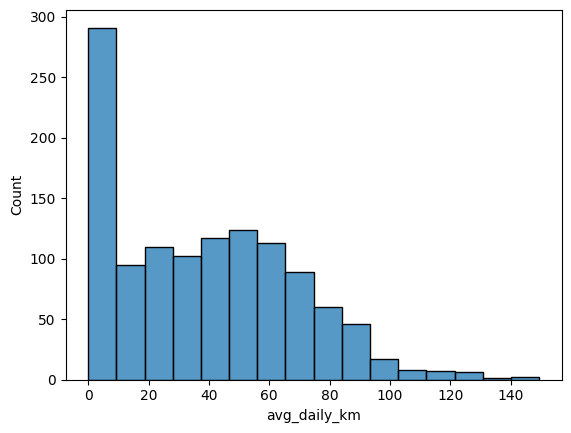

In [87]:
sns.histplot(daily_avg['avg_daily_km'])

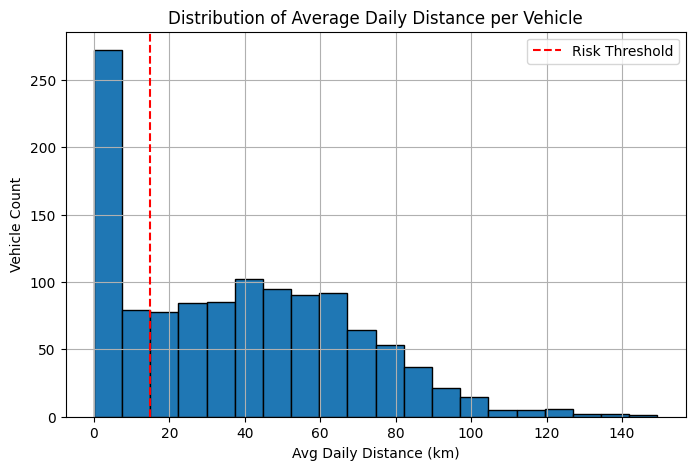

In [88]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(daily_avg['avg_daily_km'], bins=20, edgecolor='k')
plt.axvline(risk_threshold, color='red', linestyle='--', label='Risk Threshold')
plt.title("Distribution of Average Daily Distance per Vehicle")
plt.xlabel("Avg Daily Distance (km)")
plt.ylabel("Vehicle Count")
plt.legend()
plt.grid(True)
plt.show()


In [89]:
daily_avg[daily_avg['likely_default_percentile']].drop_duplicates(subset='vin')

,vin,avg_daily_km,likely_default,likely_default_percentile
16,MD9EMHDL22E217034,0.000000,True,True
17,MD9EMHDL22E217035,0.143996,True,True
21,MD9EMHDL22E217060,0.000000,True,True
22,MD9EMHDL22E217062,0.000000,True,True
23,MD9EMHDL22E217063,3.843679,True,True
...,...,...,...,...
1136,MD9EMHDL24H217088,0.000000,True,True
1145,MD9EMHDL24H217167,0.650318,True,True
1148,MD9EMHDL24H217208,0.000000,True,True
1205,MD9EMHDL24J217234,0.000000,True,True


In [18]:
default_vehicles = daily_avg[daily_avg['likely_default'] == True]

# Save to Excel
default_vehicles.to_excel("Q3_Default_Vehicles.xlsx", index=False)
